<a href="https://colab.research.google.com/github/SETIADEEPANSHU/ExtensiveVisionAIProgramme/blob/master/ENAS_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import numpy, time, matplotlib, Keras models, backend, layers and utils
# set random seed using random.seed from numpy

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
# Import cifar10 from keras datasets
# Load CIFAR10 dataset from Keras datasets module seperately as train and test datasets
# Obtain number of training and testing examples, image dimensions and number of classes

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

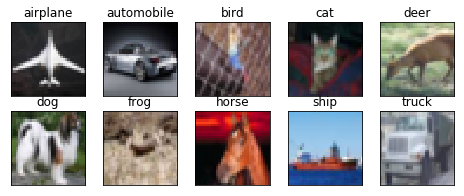

In [0]:
# Display images corresponding to each class from training dataset

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Define function to plot summarize history for accuracy and loss

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Define function to calculate accuracy

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Convert the Tensor i.e. train and test dataset to float tensors. Also perform a min-max normalization where min = 0 and max = 255
# # Convert 1-dimensional class arrays to num_classes-dimensional class matrices

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### <center> ENAS's discovered network from the macro search space for image classification(https://arxiv.org/pdf/1802.03268.pdf) <center>


![ENAS's discovered network](images/enasdiscoverednetwork.png)

### ENAS model using 2x2 MaxPool of Stride 1

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate, SeparableConv2D, DepthwiseConv2D, GlobalAveragePooling2D
from keras.models import Model

# Define the model
# Create a CNN model using Keras functions. Use relu for all layers, except at the end. The logits are passed into softmax layer to represent everything between 0 and 1.


inputs = Input(shape=(32, 32, 3))


x1 = SeparableConv2D(64, (5, 5), padding='same', activation='relu')(inputs)# Depthwise Separable Convolution.#Input channel 3, number of filters 64, filter size is 5x5 with 3 channels.Output Images size 32.
x1_n = BatchNormalization()(x1) # BatchNormalization layer
x1_n = Dropout(0.1)(x1_n)# Droput is set to 0.1


x2 = Conv2D(128, (5, 5), padding='same', activation='relu')(x1_n)# Input channel 64, number of filters 128, filter size is 5x5 with 64 channels.Output Images size 32.
x2_n = BatchNormalization()(x2) # BatchNormalization layer
x2_n = Dropout(0.1)(x2_n)# Droput is set to 0.1


x3 = Conv2D(128, (5, 5), padding='same', activation='relu')(x2_n)# Input channel 128, number of filters 128, filter size is 5x5 with 128 channels.Output Images size 32.
s1 = concatenate([x3, x1], axis = -1)# Concatenate operation
g1 = Conv2D(128, (1, 1), padding='same', activation='relu')(s1)# number of filters 128, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x3_n = BatchNormalization()(g1) # BatchNormalization layer
x3_n = Dropout(0.1)(x3_n)# Droput is set to 0.1


x4 = SeparableConv2D(256, (5, 5), padding='same', activation='relu')(x3_n)# Depthwise Separable Convolution.#Input channel 128, number of filters 256, filter size is 5x5 with 128 channels.Output Images size 32.
s2 = concatenate([x1, x4], axis = -1)# Concatenate operation
g2 = Conv2D(32, (1, 1), padding='same', activation='relu')(s2)# number of filters 32, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x4_n = BatchNormalization()(g2) # BatchNormalization layer
x4_n = Dropout(0.1)(x4_n)# Droput is set to 0.1


m1 = MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(x4) #MaxPooling layer with stride 1. Hence Output Images size 32.#Input channel 32, number of filters n/a, filter size is n/a with n/a channels.


x5 = SeparableConv2D(64, (3, 3), padding='same', activation='relu')(m1)# Depthwise Separable Convolution.#Input channel 32, number of filters 64, filter size is 3x3 with 32 channels.Output Images size 32.
s3 = concatenate([x1, x4, x5], axis = -1)# Concatenate operation
g3 = Conv2D(64, (1, 1), padding='same', activation='relu')(s3)# number of filters 64, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x5_n = BatchNormalization()(g3) # BatchNormalization layer
x5_n = Dropout(0.1)(x5_n)# Droput is set to 0.1


x6 = Conv2D(128, (5, 5), padding='same', activation='relu')(x5_n)# Input channel 64, number of filters 128, filter size is 5x5 with 64 channels.Output Images size 32.
s4 = concatenate([x3, x4, x5, x6], axis = -1)# Concatenate operation
g4 = Conv2D(128, (1, 1), padding='same', activation='relu')(s4)# number of filters 128, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x6_n = BatchNormalization()(g4) # BatchNormalization layer
x6_n = Dropout(0.1)(x6_n)# Droput is set to 0.1


x7 = SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x6_n)# Depthwise Separable Convolution.#Input channel 128, number of filters 128, filter size is 3x3 with 128 channels.Output Images size 32.
s5 = concatenate([x1, x3, x4, x5, x6, x7], axis = -1)# Concatenate operation
g5 = Conv2D(128, (1, 1), padding='same', activation='relu')(s5)# number of filters 128, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x7_n = BatchNormalization()(g5) # BatchNormalization layer
x7_n = Dropout(0.1)(x7_n)# Droput is set to 0.1


x8 = SeparableConv2D(256, (5, 5), padding='same', activation='relu')(x7_n)# Depthwise Separable Convolution.#Input channel 128, number of filters 256, filter size is 5x5 with 128 channels.Output Images size 32.
s6 = concatenate([x1, x4, x5, x7, x8], axis = -1)# Concatenate operation
g6 = Conv2D(64, (1, 1), padding='same', activation='relu')(s6)# number of filters 64, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x8_n = BatchNormalization()(g6) # BatchNormalization layer
x8_n = Dropout(0.1)(x8_n)# Droput is set to 0.1


m2 = MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(x8_n) #MaxPooling layer with stride 1. Hence Output Images size 32.#Input channel 64, number of filters n/a, filter size is n/a with n/a channels.
s7 = concatenate([x6, m2], axis = -1)# Concatenate operation
g7 = Conv2D(32, (1, 1), padding='same', activation='relu')(s7)# number of filters 32, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.


x9 = Conv2D(64, (5, 5), padding='same', activation='relu')(g7)# Input channel 32, number of filters 64, filter size is 5x5 with 32 channels.Output Images size 32.
s8 = concatenate([x1, x2, x7, x9], axis = -1)# Concatenate operation
g8 = Conv2D(64, (1, 1), padding='same', activation='relu')(s8)# number of filters 64, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x9_n = BatchNormalization()(g8) # BatchNormalization layer
x9_n = Dropout(0.1)(x9_n)# Droput is set to 0.1



x10 = SeparableConv2D(128, (5, 5), padding='same', activation='relu')(x9_n)# Depthwise Separable Convolution.#Input channel 64, number of filters 128, filter size is 5x5 with 64 channels.Output Images size 32.
s9 = concatenate([x2, x3, x5, x9, x10], axis = -1)# Concatenate operation
g9 = Conv2D(128, (1, 1), padding='same', activation='relu')(s9)# number of filters 128, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x10_n = BatchNormalization()(g9) # BatchNormalization layer
x10_n = Dropout(0.1)(x10_n)# Droput is set to 0.1



x11 = Conv2D(128, (3, 3), padding='same', activation='relu')(x10_n)# Input channel 128, number of filters 128, filter size is 3x3 with 128 channels.Output Images size 32.
s10 = concatenate([x1, x4, x5, x7, x3, x10, x11], axis = -1)# Concatenate operation
g10 = Conv2D(128, (1, 1), padding='same', activation='relu')(s10)# number of filters 128, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x11_n = BatchNormalization()(g10) # BatchNormalization layer
x11_n = Dropout(0.1)(x11_n)# Droput is set to 0.1



x12 = SeparableConv2D(256, (5, 5), padding='same', activation='relu')(x11_n)# Depthwise Separable Convolution.#Input channel 128, number of filters 256, filter size is 5x5 with 128 channels.Output Images size 32.
s11 = concatenate([x4, x7, x10, x12], axis = -1)# Concatenate operation
g11 = Conv2D(num_classes, (1, 1), padding='same', activation='relu')(s11)# number of filters is equal to number of classes, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.

#x12_n = BatchNormalization()(g11) # BatchNormalization layer
#x12_n = Dropout(0.1)(x12_n)# Droput is set to 0.1

#x13 = Conv2D(num_classes, (32, 32))(x12_n)
#out = Flatten()(x13) #The outputs from the previous layer are flattened
#out = GlobalAveragePooling2D()(x12_n)

out = GlobalAveragePooling2D()(g11)# Global Average Pooling layer. Reduces each channel to single number.
predictions = Activation('softmax')(out) #Softmax activation layer.So that the values of logits are squished between 0 and 1



model = Model(inputs=inputs, outputs=predictions)



W0614 02:28:37.004954 140505713325952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 02:28:37.041550 140505713325952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 02:28:37.048062 140505713325952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 02:28:37.094810 140505713325952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0614 02:28:37.095675 1405057133

In [0]:
# Compiles the model i.e. specify loss, type of optimizer to use while training, metrics that needs to be calculated and displayed.
# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# Displays the summary of the model i.e. gives the details of different shapes and channels in different layers of the model.

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
# Mount google drive into colab. This is to save snapshots of the model during training

from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [0]:
# Path to save the snapshots of the model

#filepath="/content/gdrive/MyDrive/ENAS_CNN/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"

filepath="/content/gdrive/My Drive/epochs_{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"

In [0]:
# create a checkpoint to save the model when accuracy improves

from keras.callbacks import *
checkpoint = ModelCheckpoint(filepath       , monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 227s 581ms/step - loss: 1.4980 - acc: 0.4514 - val_loss: 1.5257 - val_acc: 0.4853

Epoch 00001: val_acc improved from -inf to 0.48530, saving model to /content/gdrive/My Drive/epochs_001-val_acc:0.485.hdf5
Epoch 2/100
390/390 [==============================] - 221s 567ms/step - loss: 1.0458 - acc: 0.6279 - val_loss: 1.2986 - val_acc: 0.5293

Epoch 00002: val_acc improved from 0.48530 to 0.52930, saving model to /content/gdrive/My Drive/epochs_002-val_acc:0.529.hdf5
Epoch 3/100
390/390 [==============================] - 218s 559ms/step - loss: 0.8101 - acc: 0.7134 - val_loss: 0.9931 - val_acc: 0.6670

Epoch 00003: val_acc improved from 0.52930 to 0.66700, saving model to /content/gdrive/My Drive/epochs_003-val_acc:0.667.hdf5
Epoch 4/100
390/390 [==============================] - 218s 560ms/step - loss: 0.6705 - acc: 0.7660 - val_loss: 0.7258 - val_acc: 0.7561

Epoch 00004: val_acc improved from 0.66700 to 0.75610, saving model to /c

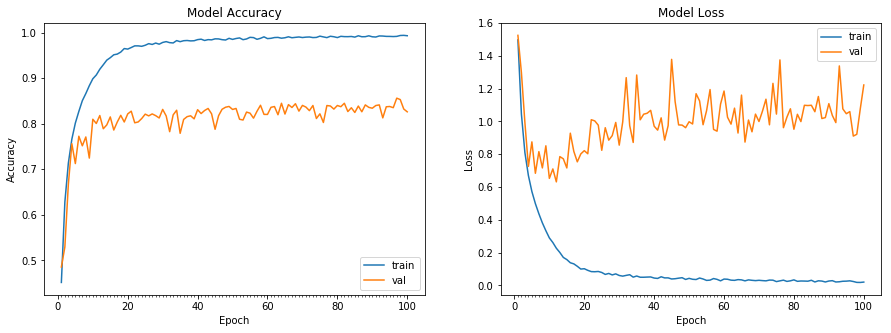

Accuracy on test data is: 82.61


In [0]:
# Train the model using fit_generator function. Also calculate and display total time taken for training. Along with this plot summarize history for accuracy and loss. Display accuracy on validation dataset.

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=callbacks_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))


*   Validation accuracy for best model is 85.61
*   Validation accuracy at the last epoch is 82.61



### <center> ENAS's discovered network from the macro search space for image classification(https://arxiv.org/pdf/1802.03268.pdf) <center>


![ENAS's discovered network](enasdiscoverednetwork.png)

### ENAS model using 2x2 MaxPool of Stride 2 and Space2Depth

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate, SeparableConv2D, DepthwiseConv2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.models import Model
import tensorflow as tf
from keras.regularizers import l2

# Create a CNN model using Keras functions. Use relu for all layers, except at the end. The logits are passed into softmax layer to represent everything between 0 and 1
# L2 regularization of 1e-2 i.e. kernel regularization is used in all convolution layers


inputs = Input(shape=(32, 32, 3))


x1 = SeparableConv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(inputs)# Depthwise Separable Convolution.#Input channel 3, number of filters 64, filter size is 5x5 with 3 channels.Output Images size 32.
x1_n = BatchNormalization()(x1) # BatchNormalization layer
x1_n = Dropout(0.1)(x1_n)# Droput is set to 0.1


x2 = Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(x1_n)# Input channel 64, number of filters 128, filter size is 5x5 with 64 channels.Output Images size 32.
x2_n = BatchNormalization()(x2) # BatchNormalization layer
x2_n = Dropout(0.1)(x2_n)# Droput is set to 0.1


x3 = Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(x2_n)# Input channel 128, number of filters 128, filter size is 5x5 with 128 channels.Output Images size 32.
s1 = concatenate([x3, x1], axis = -1)# Concatenate operation
g1 = Conv2D(128, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s1)# number of filters 128, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x3_n = BatchNormalization()(g1) # BatchNormalization layer
x3_n = Dropout(0.1)(x3_n)# Droput is set to 0.1


x4 = SeparableConv2D(256, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(x3_n)# Depthwise Separable Convolution.#Input channel 128, number of filters 256, filter size is 5x5 with 128 channels.Output Images size 32.
s2 = concatenate([x1, x4], axis = -1)# Concatenate operation
g2 = Conv2D(32, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s2)# number of filters 32, filter size is 1x1.Output Images size 32. Reduce the channels by combining them.
x4_n = BatchNormalization()(g2) # BatchNormalization layer
x4_n = Dropout(0.1)(x4_n)# Droput is set to 0.1


m1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4) #MaxPooling layer. Output Images size 16.#Input channel 32, number of filters n/a, filter size is n/a with n/a channels.

# space_to_depth functions
def space_to_depth2(x):
  return tf.space_to_depth(x,2)


def space_to_depth4(x):
  return tf.space_to_depth(x,4)


#cross=Lambda(space_to_depth)(y)  

x5 = SeparableConv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(m1)# Depthwise Separable Convolution.#Input channel 32, number of filters 64, filter size is 3x3 with 32 channels.Output Images size 16.
i1 = concatenate([x1, x4], axis = -1)# Concatenate operation
c1 = Lambda(space_to_depth2)(i1) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
s3 = concatenate([c1, x5], axis = -1)# Concatenate operation
g3 = Conv2D(64, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s3)# number of filters 64, filter size is 1x1.Output Images size 16. Reduce the channels by combining them.
x5_n = BatchNormalization()(g3) # BatchNormalization layer
x5_n = Dropout(0.1)(x5_n)# Droput is set to 0.1


x6 = Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(x5_n)# Input channel 64, number of filters 128, filter size is 5x5 with 64 channels.Output Images size 16.
i2 = concatenate([x3, x4], axis = -1)# Concatenate operation
c2 = Lambda(space_to_depth2)(i2) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
s4 = concatenate([c2, x5, x6], axis = -1)# Concatenate operation
g4 = Conv2D(128, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s4)# number of filters 128, filter size is 1x1.Output Images size 16. Reduce the channels by combining them.
x6_n = BatchNormalization()(g4) # BatchNormalization layer
x6_n = Dropout(0.1)(x6_n)# Droput is set to 0.1


x7 = SeparableConv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(x6_n)# Depthwise Separable Convolution.#Input channel 128, number of filters 128, filter size is 3x3 with 128 channels.Output Images size 16.
i3 = concatenate([x1, x3, x4], axis = -1)# Concatenate operation
c3 = Lambda(space_to_depth2)(i3) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
s5 = concatenate([c3, x5, x6, x7], axis = -1)# Concatenate operation
g5 = Conv2D(128, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s5)# number of filters 128, filter size is 1x1.Output Images size 16. Reduce the channels by combining them.
x7_n = BatchNormalization()(g5) # BatchNormalization layer
x7_n = Dropout(0.1)(x7_n)# Droput is set to 0.1


x8 = SeparableConv2D(256, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(x7_n)# Depthwise Separable Convolution.#Input channel 128, number of filters 256, filter size is 5x5 with 128 channels.Output Images size 16.
i4 = concatenate([x1, x4], axis = -1)# Concatenate operation
c4 = Lambda(space_to_depth2)(i4) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
s6 = concatenate([c4, x5, x7, x8], axis = -1)# Concatenate operation
g6 = Conv2D(64, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s6)# number of filters 64, filter size is 1x1.Output Images size 16. Reduce the channels by combining them.
x8_n = BatchNormalization()(g6) # BatchNormalization layer
x8_n = Dropout(0.1)(x8_n)# Droput is set to 0.1


m2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x8_n)  #MaxPooling layer. Output Images size 8.#Input channel 64, number of filters n/a, filter size is n/a with n/a channels.
c5 = Lambda(space_to_depth2)(x6) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
s7 = concatenate([c5, m2], axis = -1)# Concatenate operation
g7 = Conv2D(32, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s7)# number of filters 32, filter size is 1x1.Output Images size 8. Reduce the channels by combining them.


x9 = Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(g7)# Input channel 32, number of filters 64, filter size is 5x5 with 32 channels.Output Images size 8.

i5 = concatenate([x1, x2], axis = -1)# Concatenate operation
c5 = Lambda(space_to_depth4)(i5) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
c6 = Lambda(space_to_depth2)(x7) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.

s8 = concatenate([c5, c6, x9], axis = -1)# Concatenate operation
g8 = Conv2D(64, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s8)# number of filters 64, filter size is 1x1.Output Images size 8. Reduce the channels by combining them.
x9_n = BatchNormalization()(g8) # BatchNormalization layer
x9_n = Dropout(0.1)(x9_n)# Droput is set to 0.1



x10 = SeparableConv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(x9_n)# Depthwise Separable Convolution.#Input channel 64, number of filters 128, filter size is 5x5 with 64 channels.Output Images size 8.

i6 = concatenate([x2, x3], axis = -1)# Concatenate operation
c7 = Lambda(space_to_depth4)(i6) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
c8 = Lambda(space_to_depth2)(x5) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.

s9 = concatenate([c7, c8, x9, x10], axis = -1)# Concatenate operation
g9 = Conv2D(128, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s9)# number of filters 128, filter size is 1x1.Output Images size 8. Reduce the channels by combining them.
x10_n = BatchNormalization()(g9) # BatchNormalization layer
x10_n = Dropout(0.1)(x10_n)# Droput is set to 0.1



x11 = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(x10_n)# Input channel 128, number of filters 128, filter size is 3x3 with 128 channels.Output Images size 8.

i7 = concatenate([x1, x3, x4], axis = -1)# Concatenate operation
c9 = Lambda(space_to_depth4)(i7) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
i8 = concatenate([x5, x7], axis = -1)# Concatenate operation
c10 = Lambda(space_to_depth2)(i8) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.

s10 = concatenate([ c9, c10, x10, x11], axis = -1)# Concatenate operation
g10 = Conv2D(128, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(s10)# number of filters 128, filter size is 1x1.Output Images size 8. Reduce the channels by combining them.
x11_n = BatchNormalization()(g10) # BatchNormalization layer
x11_n = Dropout(0.1)(x11_n)# Droput is set to 0.1



x12 = SeparableConv2D(256, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-2))(x11_n)# Depthwise Separable Convolution.#Input channel 128, number of filters 256, filter size is 5x5 with 128 channels.Output Images size 8.
c11 = Lambda(space_to_depth4)(x4) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
c12 = Lambda(space_to_depth2)(x7) # Lambda layer where space_to_depth is applied to ensure channel sizes are same during concatenation.
s11 = concatenate([c11, c12, x10, x12], axis = -1)# Concatenate operation
#g11 = Conv2D(num_classes, (1, 1), padding='same', activation='relu')(s11)
g11 = Conv2D(num_classes, (1, 1), padding='same', activation=None)(s11)# number of filters is equal to number of classes, filter size is 1x1.Output Images size 8. Reduce the channels by combining them.

#x12_n = BatchNormalization()(g11) # BatchNormalization layer
#x12_n = Dropout(0.1)(x12_n)# Droput is set to 0.1

#x13 = Conv2D(num_classes, (32, 32))(x12_n)
#out = Flatten()(x13) #The outputs from the previous layer are flattened
#out = GlobalAveragePooling2D()(x12_n)

out = GlobalAveragePooling2D()(g11)# Global Average Pooling layer. Reduces each channel to single number.
predictions = Activation('softmax')(out) #Softmax activation layer.So that the values of logits are squished between 0 and 1



model = Model(inputs=inputs, outputs=predictions)

In [0]:
# Compiles the model i.e. specify loss, type of optimizer to use while training, metrics that needs to be calculated and displayed.
# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# Displays the summary of the model i.e. gives the details of different shapes and channels in different layers of the model.

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_8 (SeparableCo (None, 32, 32, 64)   331         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 32, 32, 64)   256         separable_conv2d_8[0][0]         
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 32, 32, 64)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_17 

In [0]:
# Mount google drive into colab. This is to save snapshots of the model during training

from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [0]:
# Path to save the snapshots of the model

filepath="/content/gdrive/My Drive/s2d_epochs_{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"

In [0]:
# Compiles the model i.e. specify loss, type of optimizer to use while training, metrics that needs to be calculated and displayed.

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.005 * 1/(1 +  0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

In [0]:
# create a checkpoint to save the model when accuracy improves

from keras.callbacks import *
checkpoint = ModelCheckpoint(filepath , monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#callbacks_list = [checkpoint]
callbacks_list = [LearningRateScheduler(scheduler, verbose=1), checkpoint]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., validation_steps=40, verbose=1, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=50)`
W0616 17:45:39.942952 139994418472832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will b

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.005.
195/195 [==============================] - 278s 1s/step - loss: 2.4390 - acc: 0.3817 - val_loss: 3.5614 - val_acc: 0.1352

Epoch 00001: val_acc improved from -inf to 0.13520, saving model to /content/gdrive/My Drive/s2d_epochs_001-val_acc:0.135.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0037907506.
195/195 [==============================] - 264s 1s/step - loss: 1.6422 - acc: 0.5190 - val_loss: 2.4730 - val_acc: 0.3132

Epoch 00002: val_acc improved from 0.13520 to 0.31320, saving model to /content/gdrive/My Drive/s2d_epochs_002-val_acc:0.313.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0030525031.
195/195 [==============================] - 260s 1s/step - loss: 1.4237 - acc: 0.5750 - val_loss: 1.9944 - val_acc: 0.3793

Epoch 00003: val_acc improved from 0.31320 to 0.37930, saving model to /content/gdrive/My Drive/s2d_epochs_003-val_acc:0.37

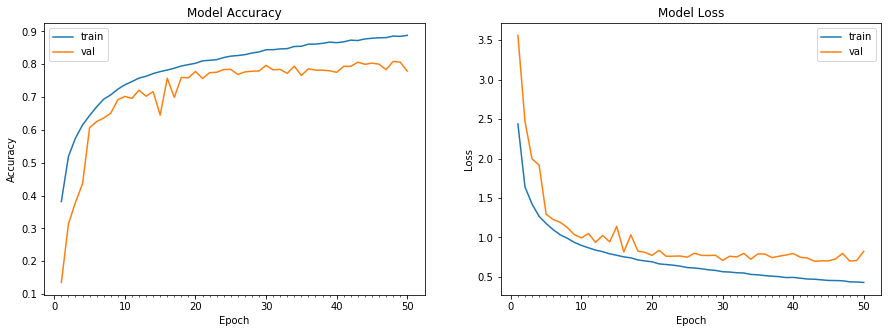

Accuracy on test data is: 77.91


In [0]:
# Train the model using fit_generator function. Also calculate and display total time taken for training. Along with this plot summarize history for accuracy and loss. Display accuracy on validation dataset.

from keras.preprocessing.image import ImageDataGenerator
from math import ceil

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

datagen.fit(train_features)

validation_steps = ceil(len(test_features)/ 256)


# train the model
start = time.time()
# Train the model
#model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
#                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
#                                 validation_data = (test_features, test_labels), verbose=1, callbacks=callbacks_list)

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = datagen.flow(test_features, test_labels, batch_size= 256, shuffle = False), validation_steps=validation_steps, verbose=1, callbacks=callbacks_list)


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
# Load the best saved model from google drive

from keras.layers import Conv2D, MaxPooling2D, Input, concatenate, SeparableConv2D, DepthwiseConv2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.models import Model
import tensorflow as tf
from keras.regularizers import l2
from keras.models import load_model

saved_model = load_model('/content/gdrive/My Drive/s2d_epochs_048-val_acc:0.809.hdf5', custom_objects={'tf': tf})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., validation_steps=40, verbose=1, callbacks=[<keras.ca..., steps_per_epoch=195, epochs=50)`


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.005.
195/195 [==============================] - 140s 717ms/step - loss: 2.6281 - acc: 0.5466 - val_loss: 3.3808 - val_acc: 0.1987

Epoch 00001: val_acc improved from -inf to 0.19870, saving model to /content/gdrive/My Drive/s2d_epochs_001-val_acc:0.199.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0037907506.
195/195 [==============================] - 134s 689ms/step - loss: 1.1419 - acc: 0.6969 - val_loss: 2.1051 - val_acc: 0.3779

Epoch 00002: val_acc improved from 0.19870 to 0.37790, saving model to /content/gdrive/My Drive/s2d_epochs_002-val_acc:0.378.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0030525031.
195/195 [==============================] - 130s 669ms/step - loss: 0.9014 - acc: 0.7350 - val_loss: 1.0478 - val_acc: 0.6812

Epoch 00003: val_acc improved from 0.37790 to 0.68120, saving model to /content/gdrive/My Drive/s2d_epochs_003-val

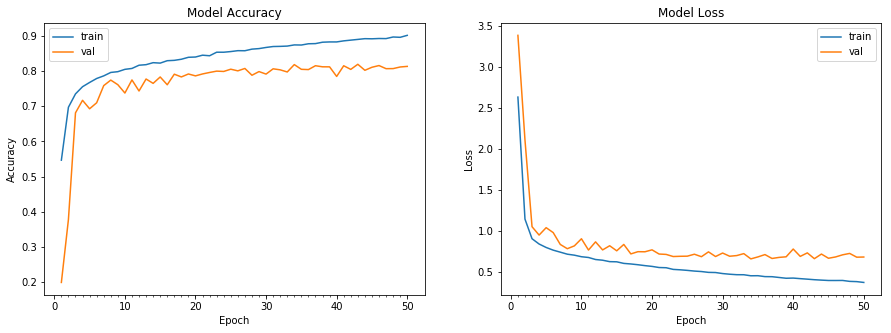

Accuracy on test data is: 10.00


In [0]:
# Train the model using fit_generator function. Also calculate and display total time taken for training. Along with this plot summarize history for accuracy and loss. Display accuracy on validation dataset.

from keras.preprocessing.image import ImageDataGenerator
from math import ceil

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

datagen.fit(train_features)

validation_steps = ceil(len(test_features)/ 256)


# train the model
start = time.time()
# Train the model
#model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
#                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
#                                 validation_data = (test_features, test_labels), verbose=1, callbacks=callbacks_list)

model_info = saved_model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = datagen.flow(test_features, test_labels, batch_size= 256, shuffle = False), validation_steps=validation_steps, verbose=1, callbacks=callbacks_list)


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

+ Validation accuracy for best model is 81.94
+ Validation accuracy at the last epoch is 81.34